# Random Forest Model Selection

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [45]:
#### Configure path
trainPath = "~/cleantrain2013Stage4.csv"

In [46]:
train = pd.read_csv(trainPath)

In [47]:
unique_users = train.user_id.unique()
print("We have data for", len(unique_users), "users")

('We have data for', 235750, 'users')


In [48]:
train.shape

(1471411, 54)

In [50]:
import random
random.seed(24)
unique_users = train.user_id.unique()
print("We have data for", len(unique_users), "users")
sel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 100000)) ]
rf_dat = train[train.user_id.isin(sel_user_ids)]
print("new sample contains", rf_dat.shape[0], "rows and", rf_dat.shape[1], "columns")

('We have data for', 235750, 'users')
('new sample contains', 619172, 'rows and', 54, 'columns')


In [51]:
del train 
import gc
gc.collect()
train = rf_dat

## Selection of test set

In [53]:
testPath = "~/cleantest2014Stage4.csv"
test = pd.read_csv(testPath)
#Select data for selected user from test set
test = test[test.user_id.isin(sel_user_ids)]

In [55]:
test.shape

(51481, 54)

In [ ]:
Note: We are saving sampled train and test to regerate the same result and use the same dataset for other ML algorithms!
It contains data for 4614 users and number of rows in the dataset are 91113
#####  train.to_csv("~/Final/sampledTrain.csv") train set 1
###### test.to_csv("~/Final/sampledTest.csv") test set 2
#train.to_csv("~/sampledTrainSet2013.csv") #313361 train set 2013
#test.to_csv("~/sampledTestset2014.csv") #25780 test set 2014

In [10]:
print("Train size:", train.shape[0])
print("Test size:", test.shape[0])

('Train size:', 313361)
('Test size:', 25780)


In [23]:
#  Missing values for origin destination
313361-199463

113898

In [57]:
missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 2:10]

,hotel_cluster,user_location_region,user_location_city,hotel_country,hotel_market,srch_destination_id,date_time,site_name
0,619172,619172,619172,619172,619172,619172,619172,619172


In [59]:
missing.transpose().iloc[0:3, 11:18]

,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co
0,395805,619172,619172,619172,619172,617680,617680


In [60]:
missing.transpose().iloc[0:3, 19:24]

,srch_children_cnt,srch_rm_cnt,srch_destination_type_id,is_booking,cnt
0,619172,619172,619172,619172,619172


As mentioned, distance between search destination and user city is missing for many instances. Rest of the values look ok. We consider imupting these missing value with -1.

In [61]:
## replace NA's in orig_destination_distance by -1
train['orig_destination_distance'].fillna(-1, inplace=True)
test['orig_destination_distance'].fillna(-1, inplace=True)
missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 10:15]

,posa_continent,orig_destination_distance,user_id,is_mobile,is_package
0,619172,619172,619172,619172,619172


#### Build random forest model using all original features!

### Model 1:

In [62]:
rawPredictors = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region',
                 'user_location_city', 'orig_destination_distance', 'user_id','is_mobile', 'is_package', 'channel',
                 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt','srch_destination_id', 'srch_destination_type_id', 'is_booking',
                  'cnt', 'hotel_continent', 'hotel_country', 'hotel_market']

In [63]:
print("We used", len(rawPredictors), "original features(excluding date/time) for the building first model")

('We used', 20, 'original features(excluding date/time) for the building first model')


In [64]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

model1_RF= RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)
cvScoreRF1 = cross_validation.cross_val_score(model1_RF, train[rawPredictors], train['hotel_cluster'], cv=5)
cvScoreRF1

array([ 0.05685084,  0.05289207,  0.06072646,  0.05540166,  0.06462505])

For the first model, we take all the raw features and number of trees = 5. We will adjust the tuning
parameters in the later step. As of now, lets observe the feature importance graph and see which features were important during tree building 
process. We first fit random forest model 

In [66]:
model1_RF.fit(train[rawPredictors], train['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Fetaure Importance Graph Model - 1 Original features

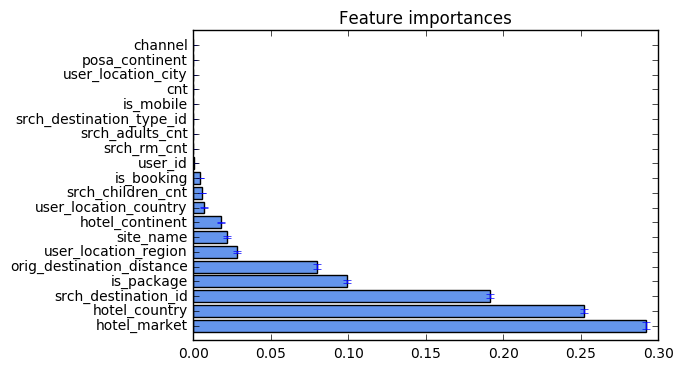

In [67]:
importances = model1_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model1_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.barh(range(len(rawPredictors)), importances[indices], yerr=std[indices], align="center", color='cornflowerblue')

impFeatures = []
for i in indices:
    impFeatures.append(rawPredictors[i])
    
plt.yticks(range(len(rawPredictors)), impFeatures)
plt.ylim([-1, len(rawPredictors)])
plt.show()

In [73]:
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model1_RF.feature_importances_), rawPredictors), 
             reverse=True)

Features sorted by their score:
[(0.2923, 'hotel_market'), (0.2522, 'hotel_country'), (0.1913, 'srch_destination_id'), (0.0991, 'is_package'), (0.0799, 'orig_destination_distance'), (0.0284, 'user_location_region'), (0.0218, 'site_name'), (0.0176, 'hotel_continent'), (0.0072, 'user_location_country'), (0.0054, 'srch_children_cnt'), (0.0045, 'is_booking'), (0.0004, 'user_id'), (0.0, 'user_location_city'), (0.0, 'srch_rm_cnt'), (0.0, 'srch_destination_type_id'), (0.0, 'srch_adults_cnt'), (0.0, 'posa_continent'), (0.0, 'is_mobile'), (0.0, 'cnt'), (0.0, 'channel')]


### Model 2 : Iteration 2

Model using only imp features 

In [74]:
impFeatureSet = ['hotel_market', 'hotel_country', 'srch_destination_id','is_package', 'orig_destination_distance', 
                  'user_location_region', 'site_name', 'hotel_continent']
model2_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)
cvScoreRF2 = cross_validation.cross_val_score(model2_RF, train[impFeatureSet], train['hotel_cluster'], cv=5)
cvScoreRF2

array([ 0.06096005,  0.06511594,  0.06515174,  0.06217746,  0.05763747])

In [75]:
model2_RF.fit(train[impFeatureSet], train['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

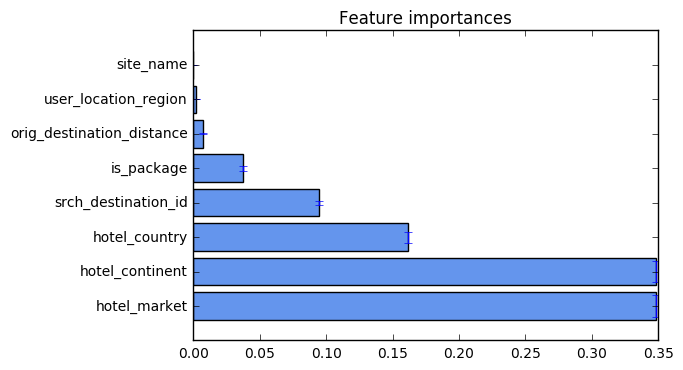

In [76]:
importances = model2_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.barh(range(len(impFeatureSet)), importances[indices], yerr=std[indices], align="center", color='cornflowerblue')
impFeatures=[]
for i in indices:
    impFeatures.append(impFeatureSet[i])
    
plt.yticks(range(len(impFeatureSet)), impFeatures)
plt.ylim([-1, len(impFeatureSet)])
plt.show()

cv score improved by only 1% using model with imp feature!

### Model 3: iteration 3
We now introduce some new features created using approach explained in ~/Final/FeatureEngScript2.R

https://bhd2.rcg.usm.maine.edu:8888/edit/Final/FeatureEngScript2.R

In [ ]:
We introduced features created by discretization 

In [83]:
## duration_of_stay in both train and test set
train["srch_ci"] = pd.to_datetime(train["srch_ci"], format='%Y-%m-%d', errors="coerce")
train["srch_co"] = pd.to_datetime(train["srch_co"], format='%Y-%m-%d', errors="coerce")
train["duration_of_stay"] = (train["srch_co"]-train["srch_ci"]).astype('timedelta64[h]')
train["duration_of_stay"] = train["duration_of_stay"]/24

test["srch_ci"] = pd.to_datetime(test["srch_ci"], format='%Y-%m-%d', errors="coerce")
test["srch_co"] = pd.to_datetime(test["srch_co"], format='%Y-%m-%d', errors="coerce")
test["duration_of_stay"] = (test["srch_co"]-test["srch_ci"]).astype('timedelta64[h]')
test["duration_of_stay"] = test["duration_of_stay"]/24

In [84]:
featureTimePca = ['year', 'month', 'day', 'hour', 'part_of_day', 'type_of_day', 'season', 
                  'duration_of_stay', 'is_alone', 
                  'dest_feature_pc1', 'dest_feature_pc2', 'dest_feature_pc3' ]


In [87]:
missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 25:36]

,year,month,day,hour,part_of_day,type_of_day,season,is_alone,dest_feature_pc1,dest_feature_pc2,dest_feature_pc3
0,619172,619172,619172,619172,619172,619172,619172,618013,617374,617374,617374


In [88]:
## replace missing values
train['is_alone'].fillna(0, inplace=True)
test['is_alone'].fillna(0, inplace=True)

train['dest_feature_pc1'].fillna(-1, inplace=True)
test['dest_feature_pc1'].fillna(-1, inplace=True)

train['dest_feature_pc2'].fillna(-1, inplace=True)
test['dest_feature_pc2'].fillna(-1, inplace=True)

train['dest_feature_pc3'].fillna(-1, inplace=True)
test['dest_feature_pc3'].fillna(-1, inplace=True)


missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 25:36]

,year,month,day,hour,part_of_day,type_of_day,season,is_alone,dest_feature_pc1,dest_feature_pc2,dest_feature_pc3
0,619172,619172,619172,619172,619172,619172,619172,619172,619172,619172,619172


In [89]:
### encode the categorical variable to numberic before applying the RF

from sklearn.preprocessing import LabelEncoder
var_mod = ['season', 'type_of_day', 'part_of_day', 'duration_of_stay']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])

In [90]:
train.shape

(619172, 55)

In [93]:
train.iloc[1:5, 25:36]

,year,month,day,hour,part_of_day,type_of_day,season,is_alone,dest_feature_pc1,dest_feature_pc2,dest_feature_pc3
2,2013,8,13,14,1,1,1,0.0,16.646431,4.634208,-0.192093
8,2013,6,5,21,2,1,1,0.0,45.864357,4.722330,-10.897558
12,2013,8,28,9,0,1,1,0.0,45.864357,4.722330,-10.897558
16,2013,1,18,21,2,1,3,0.0,45.864357,4.722330,-10.897558


In [94]:
model3_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)

cvScoreRF3 = cross_validation.cross_val_score(model3_RF, train[featureTimePca], train['hotel_cluster'], cv=5)
cvScoreRF3

array([ 0.06560209,  0.05806743,  0.06894714,  0.06698271,  0.05930156])

In [95]:
model3_RF.fit(train[featureTimePca], train['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Ater introducing this new variables, we see no noticeable improvemnet on cross validation scores. Lets fit the model 4 by coming these new features and old imp features.


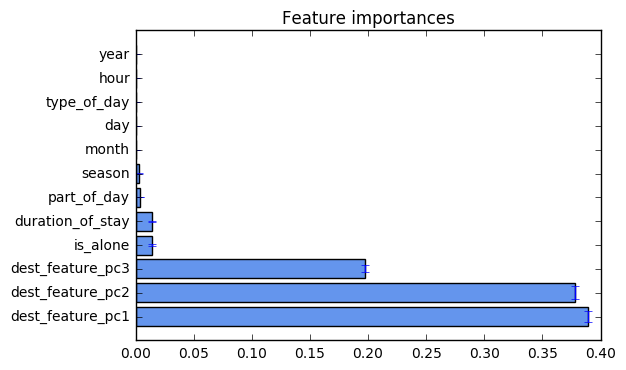

In [96]:
importances = model3_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model3_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.barh(range(len(featureTimePca)), importances[indices], yerr=std[indices], align="center", color='cornflowerblue')
impFeatures=[]
for i in indices:
    impFeatures.append(featureTimePca[i])
    
plt.yticks(range(len(featureTimePca)), impFeatures)
plt.ylim([-1, len(featureTimePca)])
plt.show()

From features plot, we found Pricipal components are important 

### Model 4 : Iteration 4 
    

In [100]:
uniqueHc_ids = len(train.hotel_country.unique())
uniqueHm_ids = len(train.hotel_market.unique())
uniqueHcont_ids = len(train.hotel_continent.unique())
print("unique values for Hotel country, market and continent are as:",uniqueHc_ids,  uniqueHm_ids, uniqueHcont_ids, "respt" )

('unique values for Hotel country, market and continent are as:', 195, 2029, 7, 'respt')


In [101]:
### encode the categorical variable to numberic before applying the RF

from sklearn.preprocessing import LabelEncoder
var_mod = ['hotel_market', 'hotel_continent', 'hotel_market']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])

In [102]:
impFeatureSet1 = ['hotel_market', 'hotel_continent', 'hotel_market'] # model 1
impFeatureSet2 = ['season', 'duration_of_stay', 'is_alone', 'dest_feature_pc1', 'dest_feature_pc2', 'dest_feature_pc3']
allImp = impFeatureSet2 + impFeatureSet1

In [103]:
model4_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)

cvScoreRF4 = cross_validation.cross_val_score(model4_RF, train[allImp], train['hotel_cluster'], cv=5)
cvScoreRF4

array([ 0.07392547,  0.08151402,  0.08526737,  0.07436421,  0.08754271])

In [104]:
model4_RF.fit(train[allImp], train['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

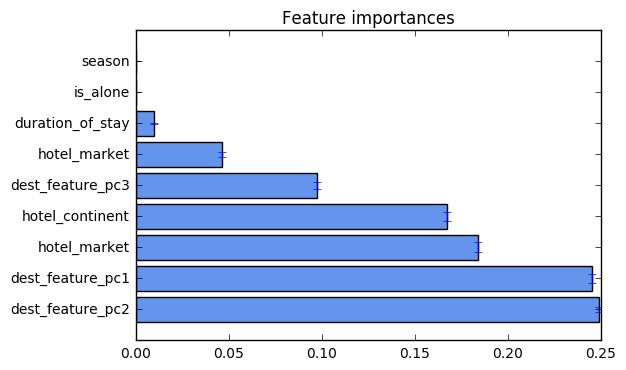

In [105]:
importances = model4_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model4_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.barh(range(len(allImp)), importances[indices], yerr=std[indices], align="center", color='cornflowerblue')
impFeatures=[]
for i in indices:
    impFeatures.append(allImp[i])
    
plt.yticks(range(len(allImp)), impFeatures)
plt.ylim([-1, len(allImp)])
plt.show()

Next, we introduce features created by book and clicks score:

In [106]:
train.columns.values

array(['Unnamed: 0', 'user_location_country', 'hotel_cluster',
       'user_location_region', 'user_location_city', 'hotel_country',
       'hotel_market', 'srch_destination_id', 'date_time', 'site_name',
       'posa_continent', 'orig_destination_distance', 'user_id',
       'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent',
       'year', 'month', 'day', 'hour', 'part_of_day', 'type_of_day',
       'season', 'is_alone', 'dest_feature_pc1', 'dest_feature_pc2',
       'dest_feature_pc3', 'clickRate', 'bookRate', 'clickMRate',
       'bookMRate', 'clickHCRate', 'bookHCRate', 'clickURate', 'bookURate',
       'clickUCRRate', 'bookUCRRate', 'clickUCRate', 'bookUCRate',
       'popScoreHmc_Count', 'popScoreU_Count', 'popScoreSite_Count',
       'popScoreDest_Count', 'popScoreCityDest_Count',
       'popScoreCityH_Count', 'duration_of_stay'], dtyp

In [119]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['user_location_country',  'user_location_region', 'user_location_city']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])

In [128]:
impfeatureSet3=['clickRate', 'bookRate','bookHCRate', 'bookURate',
                'user_location_country',  'user_location_region', 'user_location_city' ]

In [109]:
missing.transpose().iloc[0:3, 36:48]

,clickRate,bookRate,clickMRate,bookMRate,clickHCRate,bookHCRate,clickURate,bookURate,clickUCRRate,bookUCRRate,clickUCRate,bookUCRate
0,614716,614560,619101,619068,619169,619153,609369,610583,618753,618942,619130,619152


In [111]:
##We replace missing with 0
for col in impfeatureSet3:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 36:48]

,clickRate,bookRate,clickMRate,bookMRate,clickHCRate,bookHCRate,clickURate,bookURate,clickUCRRate,bookUCRRate,clickUCRate,bookUCRate
0,619172,619172,619172,619172,619172,619172,619172,619172,619172,619172,619172,619172


In [129]:
model5_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)

cvScoreRF5 = cross_validation.cross_val_score(model5_RF, train[impfeatureSet3], train['hotel_cluster'], cv=5)
cvScoreRF5

array([ 0.11391966,  0.13495511,  0.11445968,  0.11307269,  0.116729  ])

In [130]:
model5_RF.fit(train[impfeatureSet3], train['hotel_cluster'])
test_score = model5_RF.score(test[impfeatureSet3], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)

('accuracy score for test data(in %) is:', 2.0920339542743926)


###  Model 6: Iteration 6

In [131]:
popularityVar = ['popScoreHmc_Count', 'popScoreU_Count', 'popScoreSite_Count',
       'popScoreDest_Count', 'popScoreCityDest_Count',
       'popScoreCityH_Count'] 

In [135]:
##We replace missing with 0
for col in popularityVar:
    train[col].fillna(0.0, inplace=True)
    test[col].fillna(0.0, inplace=True)
missing_count = train.count(axis=0)
missing = pd.DataFrame(missing_count)
missing.transpose().iloc[0:3, 48:]

,popScoreHmc_Count,popScoreU_Count,popScoreSite_Count,popScoreDest_Count,popScoreCityDest_Count,popScoreCityH_Count,duration_of_stay
0,619172,619172,619172,619172,619172,619172,619172


In [132]:

model6_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)

cvScoreRF6 = cross_validation.cross_val_score(model6_RF, train[popularityVar], train['hotel_cluster'], cv=5)
cvScoreRF6

array([ 0.06753964,  0.06586681,  0.06789735,  0.06874329,  0.06559443])

In [136]:
model6_RF.fit(train[popularityVar], train['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [137]:
model6_RF.fit(train[popularityVar], train['hotel_cluster'])
test_score = model6_RF.score(test[popularityVar], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)

('accuracy score for test data(in %) is:', 7.7135253782949054)


In [138]:
final_set = ['popScoreHmc_Count', 'popScoreU_Count', 'popScoreSite_Count',
       'popScoreDest_Count', 'popScoreCityDest_Count',
       'popScoreCityH_Count'] + allImp

#### Model 7 :

In [139]:
model7_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)

cvScoreRF7 = cross_validation.cross_val_score(model7_RF, train[final_set], train['hotel_cluster'], cv=5)
cvScoreRF7

array([ 0.07618594,  0.08241829,  0.08059984,  0.08307019,  0.08054705])

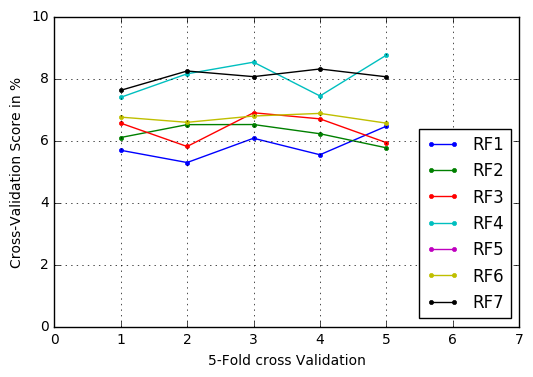

In [140]:
'Cross Validation Score Plot for the Models'
#Plot Cross Validation Score
import matplotlib.pyplot as plt
plt.xlim(*(0,7))
ylim=(0, 10)
plt.ylim(*ylim)
crossValScores = [cvScoreRF1, cvScoreRF2, cvScoreRF3, cvScoreRF4, cvScoreRF5, cvScoreRF6, cvScoreRF7]
labels = ['RF1', 'RF2', 'RF3', 'RF4', 'RF5', 'RF6', 'RF7']
crossValInPercent = [x * 100 for x in crossValScores]
for value, label in zip(crossValInPercent, labels):
    plt.plot([1, 2, 3, 4, 5],value, '.-', label=label)
plt.grid()
plt.ylabel('Cross-Validation Score in %')
plt.xlabel('5-Fold cross Validation')
plt.legend(loc = 4)
plt.show()

In [142]:
"Last model is somewhat better. "
print("cross validation score for RF -7  is (in %)", cvScoreRF7*100)

('cross validation score for RF -7  is (in %)', array([ 7.61859399,  8.24182922,  8.05998353,  8.30701889,  8.05470511]))


### Binary Random Forest

After trying everything we could not improve the performance of random forest classifier. Next step, we will try to fit binary 
classifier instead of the multi-class and try to combine the output

In [143]:
unique_clusters = train['hotel_cluster'].unique()
len(unique_clusters)
prob_booking = []

In [144]:
train_c = train

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from itertools import chain

"Fit 100 Binary classifier with target as hotel_cluster_specific Vs NONE  i.e. 1 or 0"
for cluster in unique_clusters:
    train_c.is_copy = False
    train_c["target"] = 1
    train_c["target"][train_c["hotel_cluster"] != cluster] = 0
    probs = []
    cv = KFold(len(train_c["target"]), n_folds=3)
    binaryRF = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
    for i, (tr, te) in enumerate(cv):
        binaryRF.fit(train_c[final_set].iloc[tr], train_c["target"].iloc[tr])
        preds = binaryRF.predict_proba(train_c[final_set].iloc[te])
        probs.append([p[1] for p in preds])             
    full_probs = chain.from_iterable(probs)
    prob_booking.append(list(full_probs))

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
prediction_frame = pd.DataFrame(prob_booking).T

In [147]:
prediction_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.003360,0.000002,0.013897,0.004964,0.001322,0.013505,0.002491,0.009748,0.011244,0.007897,...,0.005265,0.007079,0.007709,0.013304,0.004703,0.008409,0.012018,0.000093,0.004229,0.013725
1,0.008708,0.008594,0.006599,0.003688,0.000846,0.010517,0.002403,0.004909,0.008244,0.006311,...,0.007128,0.007085,0.014762,0.017053,0.016459,0.026570,0.009346,0.023139,0.016359,0.015837
2,0.007832,0.045401,0.004749,0.002975,0.000858,0.011119,0.002421,0.004265,0.005073,0.005286,...,0.004020,0.004382,0.015320,0.016480,0.011096,0.016770,0.005567,0.073473,0.024310,0.013680
3,0.005797,0.045401,0.002844,0.002538,0.000633,0.003134,0.000800,0.000681,0.003244,0.004145,...,0.004020,0.002306,0.012764,0.027152,0.011888,0.030783,0.004544,0.079395,0.026443,0.015477
4,0.005805,0.045401,0.003235,0.002498,0.000633,0.005986,0.000767,0.000978,0.004248,0.004145,...,0.004403,0.002306,0.009521,0.018866,0.011888,0.030783,0.004639,0.079395,0.026443,0.022258


In [155]:
del prediction_frame
import gc
gc.collect()

273

In [148]:
def find_top_5(row):
    return list(row.nlargest(5).index)
preds = []
for index, row in prediction_frame.iterrows():
    preds.append(find_top_5(row))

In [150]:
import ml_metrics as metrics
metrics.mapk([[l] for l in train_c["hotel_cluster"]], preds, k=5)

0.017849725116768841

Result of binary classifiers is even worst. So we do not try to improve this model. 


Next, step for random forest classifier is tune some parameters. We will try to increase number of trees for model 6 and hope
for the improvement. Before this, lets check model perform on the test data.


In [175]:
test.columns.values

array(['Unnamed: 0', 'srch_destination_id', 'date_time', 'site_name',
       'posa_continent', 'user_location_country', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'user_id',
       'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent',
       'hotel_country', 'hotel_market', 'hotel_cluster', 'year', 'month',
       'day', 'hour', 'season', 'duration_of_stay', 'is_alone',
       'dest_feature_pc1', 'dest_feature_pc2', 'dest_feature_pc3',
       'part_of_day_-1', 'part_of_day_evening', 'part_of_day_morning',
       'part_of_day_night', 'part_of_day_noon', 'type_of_day_0',
       'type_of_day_1'], dtype=object)

In [177]:
test = test.rename(index=str,columns={"type_of_day_0": "type_of_day_weekday", "type_of_day_1": "type_of_day_weekend"})
test.columns.values

array(['Unnamed: 0', 'srch_destination_id', 'date_time', 'site_name',
       'posa_continent', 'user_location_country', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'user_id',
       'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent',
       'hotel_country', 'hotel_market', 'hotel_cluster', 'year', 'month',
       'day', 'hour', 'season', 'duration_of_stay', 'is_alone',
       'dest_feature_pc1', 'dest_feature_pc2', 'dest_feature_pc3',
       'part_of_day_-1', 'part_of_day_evening', 'part_of_day_morning',
       'part_of_day_night', 'part_of_day_noon', 'type_of_day_weekday',
       'type_of_day_weekend'], dtype=object)

### Candidate Model

In [152]:
final_set

['popScoreHmc_Count',
 'popScoreU_Count',
 'popScoreSite_Count',
 'popScoreDest_Count',
 'popScoreCityDest_Count',
 'popScoreCityH_Count',
 'season',
 'duration_of_stay',
 'is_alone',
 'dest_feature_pc1',
 'dest_feature_pc2',
 'dest_feature_pc3',
 'hotel_market',
 'hotel_continent',
 'hotel_market']

In [154]:
model7_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)
model7_RF.fit(train[final_set], train['hotel_cluster'])
test_score = model7_RF.score(test[final_set], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)

('accuracy score for test data(in %) is:', 8.1330976476758412)


In [157]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['user_location_country',  'user_location_region', 'user_location_city', 'month','srch_destination_type_id']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])

##### No Improvement  with below combination

In [159]:
final_set2 = ['user_location_country',  'user_location_region', 'user_location_city','month','srch_destination_type_id']
model8_RF = RandomForestClassifier(n_estimators=5, min_weight_fraction_leaf=0.1)
model8_RF.fit(train[final_set2], train['hotel_cluster'])
test_score = model8_RF.score(test[final_set2], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)
cvScoreRF8 = cross_validation.cross_val_score(model8_RF, train[final_set2], train['hotel_cluster'], cv=5)
cvScoreRF8

('accuracy score for test data(in %) is:', 4.1821254443386877)


array([ 0.03195337,  0.03353895,  0.03323804,  0.03475929,  0.03167435])

In [160]:
test.shape

(51481, 55)

### Try to tune Tree sizes for Candidate Model

In [161]:
cv_scores_trees ={}
test_scores_tress={}
train_score_trees = {}
for tree_size in [5, 10, 30, 50, 100, 150]:
        modelN_RF = RandomForestClassifier(n_estimators=tree_size, min_weight_fraction_leaf=0.1)
        cvScoreRF = cross_validation.cross_val_score(modelN_RF, train[final_set], train['hotel_cluster'], cv=5)
        cv_scores_trees[tree_size]=cvScoreRF
        modelN_RF.fit(train[final_set], train['hotel_cluster'])
        trainSocre = modelN_RF.score(train[final_set], train['hotel_cluster'])
        testScore = modelN_RF.score(test[final_set], test['hotel_cluster'])    
        train_score_trees[tree_size] = trainSocre
        test_scores_tress[tree_size]=testScore

In [163]:
cv_scores_trees

{5: array([ 0.07915684,  0.07994768,  0.07829837,  0.08428967,  0.07922224]),
 10: array([ 0.08377466,  0.08070663,  0.08579227,  0.08107541,  0.0809348 ]),
 30: array([ 0.08232958,  0.08849793,  0.0834262 ,  0.08341746,  0.08170222]),
 50: array([ 0.08239416,  0.08349212,  0.08252176,  0.08466117,  0.08221922]),
 100: array([ 0.08634999,  0.08531682,  0.0834585 ,  0.08323979,  0.08135486]),
 150: array([ 0.08170795,  0.08442869,  0.08804529,  0.08502459,  0.08221922])}

In [164]:
test_scores_tress

{5: 0.08187486645558556,
 10: 0.084244672791903813,
 30: 0.082224510013403002,
 50: 0.08432237136030768,
 100: 0.083759056739379584,
 150: 0.083564810318369889}

In [165]:
train_score_trees 

{5: 0.081331197147157822,
 10: 0.083997661392957043,
 30: 0.081476552557286183,
 50: 0.08338878373053045,
 100: 0.082658776559663555,
 150: 0.083165905435000284}

In [166]:
### Mean Cv score
mean_cv = []
for key, value in cv_scores_trees.items():
    p = np.mean(value)
    mean_cv.append(p)

In [167]:
mean_cv 

[0.0839439911934865,
 0.080182960351605811,
 0.082456753624331539,
 0.083057687664748817,
 0.084285148175362853,
 0.083874678404220207]

In [168]:
mean_cvPer = [x * 100 for x in mean_cv] 
mean_cvPer

[8.39439911934865,
 8.0182960351605814,
 8.245675362433154,
 8.3057687664748823,
 8.4285148175362856,
 8.3874678404220209]

In [169]:
# get % train score for each trees
import math
trainScorePer = []
for key, value in train_score_trees.items():
    p = math.ceil(value*100*100)/100
    trainScorePer.append(p)
trainScorePer    

[8.27, 8.14, 8.4, 8.34, 8.32, 8.15]

In [170]:
import math
testScorePer = []
for key, value in test_scores_tress.items():
    p = math.ceil(value*100*100)/100
    testScorePer.append(p)
testScorePer    

[8.38, 8.19, 8.43, 8.44, 8.36, 8.23]

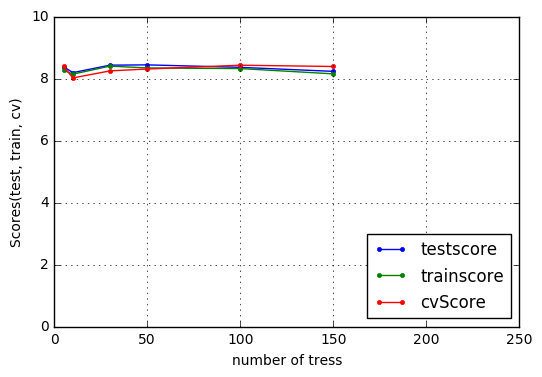

In [174]:
#Plot Cross Validation Score
import matplotlib.pyplot as plt
plt.xlim(*(0,250))
ylim=(0, 10)
plt.ylim(*ylim)
#labels = ["testscore", "trainscore", "cvScore"]
plt.plot([5, 10, 30, 50, 100, 150],testScorePer, '.-', label='testscore')
plt.plot([5, 10, 30, 50, 100, 150],trainScorePer, '.-', label='trainscore')
plt.plot([5, 10, 30, 50, 100, 150],mean_cvPer, '.-', label='cvScore')
plt.grid()
plt.ylabel('Scores(test, train, cv)')
plt.xlabel('number of tress')
plt.legend(loc = 4)
plt.show()

In [173]:
## Lest save the data state to fit some other model.
train.to_csv("~/sampledTrain13.csv")
test.to_csv("~/test2014Sampled.csv")

In [177]:
final_set2 = ['user_location_country',  'user_location_region', 'user_location_city','month','srch_destination_type_id']
model9_RF = RandomForestClassifier(n_estimators=30, min_weight_fraction_leaf=0.1, max_features = 'sqrt')
model9_RF.fit(train[final_set2], train['hotel_cluster'])
test_score = model9_RF.score(test[final_set2], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)
cvScoreRF9 = cross_validation.cross_val_score(model9_RF, train[final_set2], train['hotel_cluster'], cv=5)
cvScoreRF9*100

('accuracy score for test data(in %) is:', 4.197665158019463)


array([ 3.15577873,  3.25054902,  3.31249899,  3.45735445,  2.68759441])

In [193]:
# Important variables
final_set

['popScoreHmc_Count',
 'popScoreU_Count',
 'popScoreSite_Count',
 'popScoreDest_Count',
 'popScoreCityDest_Count',
 'popScoreCityH_Count',
 'season',
 'duration_of_stay',
 'is_alone',
 'dest_feature_pc1',
 'dest_feature_pc2',
 'dest_feature_pc3',
 'hotel_market',
 'hotel_continent',
 'hotel_market']

### Final Model - RF candidate model 1

In [179]:
model10_RF = RandomForestClassifier(n_estimators=30, min_weight_fraction_leaf=0.1)
model10_RF.fit(train[final_set], train['hotel_cluster'])
test_score = model10_RF.score(test[final_set], test['hotel_cluster'])
print("accuracy score for test data(in %) is:",test_score*100)

('accuracy score for test data(in %) is:', 8.7857656222684106)


In [186]:
cvScoreRF10 = cross_validation.cross_val_score(model10_RF, train[final_set], train['hotel_cluster'], cv=5)
cvScoreRF10*100

array([ 7.79378048,  8.5284524 ,  7.99538091,  8.34336109,  8.21061305])

In [192]:
print("Average validation score is ", cvScoreRF10.mean()*100)

('Average validation score is ', 8.1743175845796632)
